In [1]:
%matplotlib inline
code_path='.'

## Audio Processing, Video Processing and Computer Vision
## Grado en Ciencia e Ingeniería de Datos

# LAB SESSION 5: OBJECT DETECTION WITH CNNs


### Miguel Molina Moreno


<center><img src='http://www.tsc.uc3m.es/~igonzalez/images/logo_uc3m_foot.jpg' width=400 /></center>

## Objectives 

The main goal of this session is that the student investigates a Region-Convolutional Neural Network (R-CNN) that incorproates a Region Proposal Network (RPN) in the context of the object detection task. In other words, over a certain image, we will classify certain objects and their locations based on a set of predefined classes.

Particularly, we will work with Faster-RCNN [1], the first network to use an automatic strategy for region proposal. We will use part of the PASCAL VOC dataset to conduct our experiments. 

## References

- [1] Faster-RCNN. https://arxiv.org/abs/1706.05587
- [2] PASCAL VOC 2012 dataset. http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html
- [3] https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection
- [4] https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
- [5] Fast-RCNN y ROIPooling: https://arxiv.org/abs/1504.08083
- [6] https://en.wikipedia.org/wiki/File:RoI_pooling_animated.gif
- [7] FPN: https://arxiv.org/abs/1612.03144

## Submission and Evaluation

The submission required for this lab is an executed version of this notebook (all outputs must be visible) with the required implementations and answers. Please use figures and images to properly support and justify your claims. 

__*Please make sure that the results can be visualized before submitting the notebook to AulaGlobal.*__

## Before we begin

Some previous steps need to be taken for the use of Google Colaboratory. The material of the lab needs to be unzipped into the Google Drive directory where this notebook is located. The name of this directory needs to be `objdetection`. Once this is done, the following code needs to be run after properly specifying the path to the directory (variable `path`):

In [2]:
#uncomment only if you plan to execute this in Google Colab
#from google.colab import drive
#import os, sys
#from shutil import copyfile

#drive.mount('/content/drive')
#print(os.getcwd())
#code_path = 'YOURPATH' # <-- Full path prefix to objdetection dir
#sys.path.append(code_path) 

#copyfile(code_path + '/myVOC4.zip', './myVOC4.zip') #Copy db files to our working folder

# Ignore warnings (when debugging, comment the next two lines)
#import warnings
#warnings.filterwarnings("ignore")


Now, we will decompress the dataset to a local folder to optimize data loading speed.

In [3]:
#NOTE: Run this only once, in the machine where you want to run your code, then comment these lines
#import zipfile
#zipPath='./myVOC4.zip' #path of the 1st zip file
#dataFolder='.' #We extract files to the current folder
#with zipfile.ZipFile(zipPath, 'r') as zip_ref:
#    zip_ref.extractall(dataFolder)


Additionally, to run the code in a GPU environment (recommended) go to `Entorno de ejecución->Cambiar tipo entorno de ejecución` and choose GPU in `acelerador por hardware`.

## Part 1. Theory.

Before we learn how a Faster RCNN is implemented, let us remember some key aspects from the theory.

### Object detection

In object detection, an object is defined with respect to a _bounding box_, which completely surounds the object. The bounding box is defined with respect to its location (usually its center or top-left coordinate) and its size (width and length). This means that 4 numbers are required to do so (see image below). Usually, the 4 coordinates are normalized by the image dimensions, so that they can take values in the range [0,1].

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/cs.PNG">

Each object will also have an associated label depending on which predefined category it belongs to.

### Faster-RCNN

This section will focus on some key concepts regarding Faster-RCNNs. However, it is highly recommended to review the original paper [1] and the course slides.

Faster-RCNN is a _framework_ that adapts a classification-oriented CNN to object detection. To do so, a _backbone_ is used consisting on the feature extraction layers of a pre-trained CNN. From this point, two  processing blocks are used to simultaneously infer an object location and its associated class. These blocks are a *Region Proposal Network (RPN)*, and a *RoI pooling* layer followed by a classification network (see image below).

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/faster.JPEG">

Thus, the specific layers in Faster RCNNs (after the backbone is run) work over a high-level feature map in which both the bounding boxes and the defining features have to be found. This feature map does not have the same size of the image, since strides>1 are used in the backbone layers that reduce the spatial dimension of the input tensor. In particular,  we define a global stride that indicates the accumulated spatial subsampling factor: e.g. if the size of the input image is H x W and the global stride is 16, then the high level feature map that goes to the RPN and Roi Pooling blocks is H/16 x W/16. 


#### Region Proposal Network (RPN)

The main goal of this block is to obtain the areas of the image (or rather, of the feature maps) that are likely to contain an object. Therefore, we consider that each spatial location of the feature map may become the center of _k_ reference bounding boxes, known as _anchors_ in the algorithm. Typically, _k_>1, as we consider various sizes and aspect ratios (e.g. often, k=9, considering 3 sizes: 128, 256 and 512 pixels; and 3 aspect ratios 1:1, 1:2 and 2:1). An example of the anchors' locations and their representations can be seen in the images below.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/anchor_centers.png">

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/anchors-progress.png">

From the amount of available anchors ($k \cdot H/16 \cdot W/16$), only some of them match the actual position and shape of the objects present in the image. Hence, the first task of the RPN, executed for each anchor, to decide if the anchor is positive (it contains an object) or negative (it does not).

In order to train the corresponding layers in the RPN, we define a loss function $L_{objectness}$, which is a negative binary cross entropy between the out probabilities of the RPN and the labels. To provide the necessary ground truth labels, we rely on a metric called IoU - _Intersection over Union_ -, which stands for the intersection over union between the bounding box proposed by an anchor and the ground truth bounding box of an object. Anchors with a high IoU are labeled as positive (e.g. IoU>0.7), anchors with a low value (e.g. IoU<0.3) are labeled negative, whereas anchors with ambiguous values of IoU (e.g. 0.3<IoU<0.7) do not contribute to the training stage). See [1] for more details.

The number of sizes and shapes in the anchors, however, are limited by design and, hence, insufficient to represent the object's shape precisely. Thus, for the anchors considered as positive (those with high objectness score) the bounding box is then adjusted through a regression loss function $L_{reg}$, which aims to estimate the the difference between the real bounding box and the anchors' one. Therefore, the bounding box finally predicted by the RPN can be seen as a slight deviation of the original one proposed by the anchor.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/reg.PNG">

In summary, $L_{objectness}$ finds the best anchors to represent the obejcts in the image while $L_{reg}$ adapts those anchors to the true shape of the object. 


#### _RoI pooling_ and classification

Up to now, objects have been defined category-agnostically (without considering their class). Once the objects have been located, we need to determine their category. To do this, we need to crop the areas of the feature maps defined by the bounding boxes and pass them to a final set of fully-connected layers. However, this cannot be done directly, as it would require all crops to be the same size, which is almost always false. To address this issue, we use a *RoI pooling* strategy, which adapts the features map to a fixed size that can feed the subsequent layers.

This strategy simply consists on defining a grid over the feature map's bounding box (the ROI) which will be used to pool values from. The bounding box's size is $H_{bb}$ x $W_{bb}$, so if we set the grid to be $H_{fix}$ x $W_{fix}$ with each cell of the grid being size $H_{bb}/H_{fix}$ x $W_{bb}/W_{fix}$, we can apply a max pooling from each cell to obtain an adapted, fixed-sized representation of the feature map. This can be seen in the animation below.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/RoI_pooling_animated.gif">

Once the fixed-sized representations are computed, we can use the network to classify the objects according to their category. The network is trained using a loss function $L_{cls}$. Additionally, the bounding boxes are refined with the newly obtained information (RoI pooling representation and class categorization) with a new regressive loss function $L_{reg2}$. An example of object detection for a certain input image is shown below (bounding box + object class with associated likelyhood).

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/result.PNG">


### Additional information for this lab: FPN 

In object detection networks, detection object at different scales is challenging (particularly for small objects). The traditional strategy for this is the construction of a pyramid for the image at different scales (see the figure below), and the application of the same detection procedure at each scale. However, in the case of neural networks, the processing of different versions of the same image requires both memory and time. Alternatively, a more efficient multiscale processing can be applied to some intermediate feature representations obtained in the backbone network, as they will show notably smaller spatial dimensions.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/pyramid.jpeg">

Note that feature maps near the input are not useful for especially large object detection, as they are composed of low-level structures (edges) of the image. For this reason, frequently, prior to an RPN, a * Feature Pyramid Network * (FPN) is applied, a feature extractor that generates feature maps of different spatial resolutions (thus multi-scale) with different information for each scale, like the figure below shows.

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/fpn.png">

On each of these feature maps, the RPN proposes the *anchors*. Specifically, depending on the spatial resolution of each feature map, the RPN uses different translation-invariant *anchors*: the RPN proposes the smallest-size translation-invariant *anchors* on the higher-resolution feature map (bottom layers of the backbone) and the largest translation-invariant *anchors* over the lower resolution map locations (top layers of the backbone). This makes sense from a logical point of view: on maps with more low-level information, the small *anchors* are placed to search for small objects, and on maps with high-level information, the larger *anchors* are placed, which look for objects that make up a large percentage of the image area.

For more detailed information, see [7].

### Evaluation for object detection

The performance of the detection system is analyzed in terms of the F1 score. However, to define this measure, we mustfirst introduce the precision and the recall. Each of these measures are defined below.

The __precision__, for the case of object detection, represents the percentage of correctly detected objects out of the total number of detected objects (correct and incorrect). It is calculated as:

\begin{equation}
P=\frac{TP}{TP+FP},
\end{equation}

where $TP$ is the number of *true positives* (correctly identified objects) and $FP$ the number of *false positives* (incorrectly identified objects).

The __recall__ represents the percentage of correctly detected objects out of the total number of objects present in the images. It is calculated as:


\begin{equation}
R=\frac{TP}{TP+FN},
\end{equation}

where $ FN $ represents the number of *false negatives* (objects present in the images but not detected).

Nevertheless, the network provides a series of *bounding boxes* on the image that can overlap with the *ground truth* to a greater or lesser extent. Thus, we have to establish a __criterion to consider a prediction as correct__. This is usually established in the quality of segmentation, by means of the *Intersection over Union*, __IoU__ measure, also called *Jaccard Index* (JI). The $ IoU $ measures the similarity between two regions $A$ and $B$ as:

\begin{equation}
IoU=\frac{A \cap B}{A \cup B}
\end{equation}

where $\cap$ is the intersection between the regions (area in common) and $\cup$ is the union or total area that they cover between them. A minimum threshold of $IoU_{th} = 0.5 $ or $ IoU_ {th} = 0.7$ is usually set to consider a detection as correct. An example of the $ IoU $ measure on *bounding boxes* can be seen below (it will be used in our object detection architecture).

<img src="https://raw.githubusercontent.com/plasavall/detection_images/main/iou.png" width="500 pix">

Similarly, the $IoU$ measure can be used to set quality in object instance segmentation.

Finally, once these measures have been described, the F1 score can be defined. The F1-*score* considers both the precision and the recall to obtain a weighted harmonic mean between them such that:

\begin{equation}
F1=2\cdot \frac{P\cdot R}{P+R},
\end{equation}

Therefore, this measure summarizes in a single figure the performance of our object detector for a given __point of operation__. The network provides a series of *bounding boxes* with an associated __*score*__ and predicted category, which indicates how likely it is that an object of that certain class exists in that region. However, the precision, the recall and the F1 measure requires hard decisions, which will be generated depending  on the __operation point__ chosen for the system, namely an object detection threshold (defined as th_score later in the notebook).

### The definition of the object detection problem

The database that will be used in practice is a subset of the PASCAL VOC 2012 database [2]. This database contains images with various objects belonging to 20 categories:

- __Person__: _person_
- __Animal__: _bird, cat, cow, dog, horse, sheep_
- __Vehicle__: _aeroplane, bicycle, boat, bus, car, motorbike, train_
- __Indoor__: _bottle, chair, dining table, potted plant, sofa, tv/monitor_

During this session you are going to work on the set __Indoor__. Specifically, objects of the classes: _bottle, chair_ and _dining table_ will be detected. The images are provided in separate folders for training and testing. The sets are distributed as follows:
- Training: 234 images, in which there are 90 objects of the *bottle* class, 125 of the *chair* class, 36 of the *dining table* class and 40 of the *sofa* class.
- Test: 68 images, in which there are 36 objects of the *bottle* class, 52 of the *chair* class and 15 of the *dining table* class and 27 of the *sofa* class.

## Part 2. Implementation.

First, we import the necessary libraries

In [4]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile, ImageDraw
import cv2
import random
import matplotlib.pyplot as plt
import pdb
# Set random seed for replicability (MANUALLY)
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
# torch uses some non-deterministic algorithms
torch.backends.cudnn.enabled = False

Random Seed:  999


### Runtime input variables

Some inputs are defined:

- **data_dir** - the root directory of the database, described later.
- **num_workers** - the number of threads to load the data with the DataLoader class.
- **batch_size** - the size of the _batch_.
- **num_classes** - the number of classes to detect.
- **class_names** - the names of the classes to detect.
- **num_epochs** - number of _epochs_ for network training.
- **step_size** - number of _epochs_ after which the learning rate is reduced by a factor of 0.1.
- **lr** - initial learning rate.
- **device** - the device (GPU or CPU) for execution.

In [5]:
data_dir = "myVOC4"
num_workers=8         # to debug, fix num_workers=0
batch_size = 1        # Training and test (if we use 1 we don't need to resize the images)
num_classes=5         # Number of classes
class_names=['background','bottle','chair','dining_table','sofa']
num_epochs = 6
step_size= 5
lr=0.001
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Modified library 

For this session, a modified version of the torchvision library will be used, which we will name torchvision_05. This modified version allows to train our detection network with images that do not contain any objects, whereas the original version does not allow it. Likewise, it provides us with the information of the _anchors_ selected for each object during the inference. We import the necessary modules

In [6]:
import torchvision_05
from torchvision_05.models.detection.rpn import AnchorGenerator
from torchvision_05.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision_05.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms.functional as F

### Network

The network to be used follows the Faster-RCNN architecture using a ResNet-50 as backbone network. Specifically, the first 4 blocks of this network are used, composed of convolutional layers, batch normalization (whose parameters are frozen) and non-linear layers. We also add a FPN, _Feature Pyramid Network_, which extracts characteristics from the resulting maps of the network at different scales. After this *backbone*, Faster-RCNN's own modules are placed: the region proposition network and the _RoI pooling_ and classification.

The following is the function that builds the network.

In [7]:
def get_model_detection(num_classes):
    # load a Faster RCNN model pre-trained on COCO
    model = torchvision_05.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
        
    return model

In the next cell, we will load the model, please stop to analyze each of the layers that define the model and its characteristics.

In [8]:
model_ft = get_model_detection(num_classes)
print(model_ft)
# Send the model to GPU
model_ft = model_ft.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False

### Database

The function to load the database is defined below. To simplify its treatment, the database is provided in the form of images (`images`) and masks for each of the object instances (` instances`). Thus, for each image there are as many masks as there are objects in it (with the segmentation of each one of them). Also, the category of each object is encoded in the name of the image. In addition, the `classes` semantic segmentation and the `masks` instance segmentation are provided.

Try to understand the return variables of this function.

**IMPORTANT**: input images are not normalized in this case. The _framework_ itself performs normalization internally with the mean of ImageNet samples.

In [9]:

class myVOCDataset(object):
    def __init__(self, root, train):
        self.root = root
        self.train = train
        # load all image files, sorting them to
        # ensure that they are aligned
        

        
        if (self.train):
            self.imgs = [os.path.join(root,name)
                 for root, dirs, files in os.walk(root)
                 for name in files if ('train'+os.path.sep+'images' in root)
                 if name.lower().endswith(".jpg")]
            #TOREMOVE - #DEBUG
            maxSize=0
            if maxSize>0:
                self.imgs=self.imgs[0:maxSize]
            ###
        else:
            self.imgs = [os.path.join(root,name)
                 for root, dirs, files in os.walk(root)
                 for name in files if ('test'+os.path.sep+'images' in root)
                 if name.lower().endswith(".jpg")]



    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.imgs[idx]
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        img = Image.open(img_path).convert("RGB")
        
        # Independent annotations for each object
        file=self.imgs[idx].split(os.path.sep)[-1]
        self.masks = [os.path.join(self.root,name)
                        for self.root, dirs, files in os.walk(self.imgs[idx].replace('images','instances').replace(file,''))
                        for name in files 
                        if (name.startswith(file[:-4]+'_'))]
        if (not self.masks):
            masks=np.array(Image.new('L', img.size))
            labels=np.zeros((0,),dtype=np.int64)
            num_objs=0
        else:
            mask=np.zeros((len(self.masks),img.size[1],img.size[0]),dtype=np.uint8)
            labels=np.zeros((len(self.masks),),dtype=np.int64)
            for j in range(len(self.masks)):
                mask[j,:,:]=np.array(Image.open(self.masks[j]))
                labels[j]=int(self.masks[j].split('_')[-1][:-4])
            num_objs = len(mask)
            masks=np.asarray(mask)
                            
        boxes = []

        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            # Get aspect ratio
            W=xmax-xmin
            H=ymax-ymin
            if (W==0 or H==0):
                labels=np.delete(labels,i)
            else:
                boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        num_objs = boxes.size(0)
        # get the labels
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        # We need the area to filter the empty images
        if (not boxes.size()==torch.Size([0])):
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = torch.tensor([0.])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area

        img=F.to_tensor(img)
        return img, target, img_path

    def __len__(self):
        return len(self.imgs)

We use the previously defined function to load the data. 

In [10]:
import utils

# use our dataset and defined transformations
dataset = myVOCDataset(data_dir, train=True)
dataset_test = myVOCDataset(data_dir, train=False)

# define training and test data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, # to debug, fix num_workers=0
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=num_workers,
    collate_fn=utils.collate_fn)

### Evaluation metrics

Likewise, the function that tests the quality of our model is defined in terms of object detection (precision and recall) and classification (among the detected objects, which ones are correctly classified according to their category).
The function receives as parameters:
- __model__: the CNN to evaluate.
- __dataloader__: the loader of the test data.
- __class_names__: names of the object classes to detect (always include the *background* class first).
- __th_score__: the network provides each detected object with a probability between 0 and 1. This threshold discards objects with objectness such that $Pr(object)<score_{th}$.
- __th_iou__: imposes a minimum IoU threshold from which to consider a detection as correct, that is, it is a decision on how to evaluate the system.
- __result_dir__: path to the results directory.
- __SAVE_OPT__: to save or not the test results as images with the * ground truth *, the predicted * bounding boxes * and the corresponding * anchors *.
- __SAVE_FULL__: to save the total results on each image (True) or save them in different folders for each size of * anchor * for later analysis (False).
- __VERBOSE__: prints on screen the total evaluation measures (without taking into account each class) if it is False, or the totals and marginals for each class if it is True.
- __batchsize__: must be equal to 1.

The function provides as outputs:
- __precision_RPN__ - Precision for object detection of the RPN.
- __recall_RPN__: the recall for the detection of RPN objects.
- __f1_score_RPN__: the F1 score for detection, which we take as the main measure of system performance.
- __cm_global__: confusion matrix between classes for classification.
- __prec_rec_global__: global precision and recall for the multiclass detection problem.
- __prec_rec_marginal__: per-class precision and recall for the multiclass detection problem.
- __total_anchors__: all the anchors of the network for the test set, for further analysis.
- __total_labels__: labels of said anchors.

__IMPORTANT:__ It should be noted that the inference function returns the evaluation measures for both the RPN (`precision_RPN`,` recall_RPN` and `f1_score_RPN`), that is, these measures refer to the *objectness* or ability to detect objects from the network regardless of its category; and the final detection scores of the network (`cm_global`,` prec_rec_global` and `prec_rec_marginal`). Of course, errors in RPN are also transfered to the global metrics, decreasing the performance.

In [11]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
from sklearn.preprocessing import LabelBinarizer

# Auxiliary function to compute the intersection over union between 2 bounding boxes
from external import bb_intersection_over_union


def test_detection_model(model, dataloader, class_names, th_score, th_iou, result_dir, SAVE_OPT, SAVE_FULL, VERBOSE, batch_size=1):
    since = time.time()
    # Standard values for anchors and image size
    bins=[48,96,192,384]
    size_anchors=[32,64,128,256,512]
    min_size = 800
    max_size = 1333
    model.eval()   # Set model to evaluate mode

    # Detection measurements
    ret = 0
    rel = np.zeros((len(class_names)-1,),dtype=int)
    ret_rel = np.zeros((len(class_names)-1),dtype=int)
    
    # Classification measurements
    y_true=np.zeros((0,),dtype='int')
    y_pred=np.zeros((0,),dtype='int')
    y_score=np.zeros((0,),dtype='int')
    batch_counter = 0
    total_anchors=np.zeros((0,4),dtype='float32')
    total_labels=np.zeros((0,),dtype=int)
    print('Evaluating...')
    with torch.no_grad():
        # Iterate over data.
        for inputs, targets, paths in dataloader:
            batch_counter = batch_counter + 1
            inputs = list(image.to(device) for image in inputs)
            labels = [{k: v.to(device) for k, v in t.items()} for t in targets]
            # Scale factor (useful for anchor extraction)
            size_img=inputs[0].size()[1:]
            scale_factor=min_size/min(size_img)
            if max(size_img) * scale_factor > max_size:
                scale_factor = max_size / max(size_img)
            # Let's create the ground-truth boxes and labels
            if (np.array(labels[0]['boxes'].cpu()).shape[0]==0):
                gt_boxes=np.zeros((0,4),dtype='float32')
            else:
                gt_boxes=np.array(labels[0]['boxes'].detach().cpu())
                gt_labels=np.array(labels[0]['labels'].detach().cpu())
                # Relevant objects per class
                for j in range(1,len(class_names)):
                    rel[j-1]=rel[j-1]+np.sum(gt_labels==j)
            # Prediction: returns boxes, scores (objectness), labels (class) and anchors
            pred = model(inputs)
            pred[0]['scores']=pred[0]['scores'].detach().cpu()
            pred[0]['boxes']=pred[0]['boxes'].detach().cpu()
            pred[0]['labels']=pred[0]['labels'].detach().cpu()
            pred[0]['anchors']=pred[0]['anchors'].detach().cpu()
            # We use only those with scores>th_score and convert them to numpy arrays
            if (len(pred[0]['scores'].numpy())==0):
                pred_boxes=np.zeros((0,4),dtype='float32')
                pred_labels=np.zeros((0,),dtype=int)
            else:
                pred_score = list(pred[0]['scores'].numpy())
                if (pred_score[0]>th_score):
                    pred_t = [pred_score.index(x) for x in pred_score if x>th_score][-1]
                    pred_class = [class_names[i] for i in list(pred[0]['labels'].numpy())]
                    pred_labels = pred[0]['labels'].numpy()
                    pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['boxes'].numpy())]
                    pred_boxes = np.array(pred_boxes[:pred_t+1])
                    pred_anchors = [[i[0], i[1], i[2], i[3]] for i in list(pred[0]['anchors'].numpy())]
                    pred_anchors = np.array(pred_anchors[:pred_t+1])
                    total_anchors = np.concatenate((total_anchors,pred_anchors),axis=0)
                    pred_class = pred_class[:pred_t+1]
                    pred_labels = pred_labels[:pred_t+1]
                    total_labels = np.concatenate((total_labels,pred_labels),axis=0)
                else:
                    pred_boxes=np.zeros((0,4),dtype='float32')
                    pred_labels=np.zeros((0,),dtype=int)

                    
            # Retrieved objects 
            ret=ret+len(pred_labels)
            assigned=np.zeros((pred_boxes.shape[0],),dtype='float')
            # Detection statistics: we compute the intersection over union between the ground-truth objects
            # and the retrieved ones, if it exceed th_iou, the detection is considered as a good one
            for j in range(gt_boxes.shape[0]):
                y_true=np.concatenate((y_true,gt_labels[j][np.newaxis]),axis=0)
                if pred_boxes.shape[0]>0:
                    ious=np.zeros((pred_boxes.shape[0],),dtype='float')
                
                    for k in range(pred_boxes.shape[0]):
                        ious[k]=bb_intersection_over_union(gt_boxes[j,:],pred_boxes[k,:])
                    iou_max=np.max(ious)
                    pos=np.argmax(ious)
                else:
                    iou_max=0
                if (iou_max>th_iou):
                    ret_rel[gt_labels[j]-1]+=1
                    y_pred=np.concatenate((y_pred,pred_labels[pos][np.newaxis]),axis=0)
                    assigned[pos]=1;
                else:
                    y_pred=np.concatenate((y_pred,np.zeros((1,))),axis=0)
            #else:
            #    y_pred=np.concatenate((y_pred,np.zeros((1,))),axis=0)
            
            #Now add non-assigned predictions as false detections to the statistics
            for k in range(pred_boxes.shape[0]):
                if assigned[k]==0:
                    y_true=np.concatenate((y_true,np.zeros((1,))),axis=0)
                    y_pred=np.concatenate((y_pred,pred_labels[k][np.newaxis]),axis=0)
            

            # Save the images with detections and ground-truth objects in a new folder, to analyze the results
            if SAVE_OPT and SAVE_FULL:
                aux=paths[0].split('/')
                folder_path=os.path.join(result_dir,'instances_pred_full')
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                img=np.array(F.to_pil_image(inputs[0].cpu()))
                for i in range(pred_boxes.shape[0]):
                    cv2.rectangle(img, (int(pred_boxes[i][0]),int(pred_boxes[i][1])), (int(pred_boxes[i][2]),int(pred_boxes[i][3])),color=(255, 0, 0), thickness=1)
                    cv2.putText(img,pred_class[i], (int(pred_boxes[i][0]),int(pred_boxes[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                for i in range(gt_boxes.shape[0]):
                    cv2.rectangle(img, (gt_boxes[i][0],gt_boxes[i][1]), (gt_boxes[i][2],gt_boxes[i][3]),color=(0, 255, 0), thickness=1)
                    cv2.putText(img,class_names[gt_labels[i]], (gt_boxes[i][0],gt_boxes[i][1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                pred_path=folder_path+'/'+aux[-1]
                cv2.imwrite(pred_path,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            elif SAVE_OPT and not SAVE_FULL:
                aux=paths[0].split('/')
                folder_path=os.path.join(result_dir,'instances_pred')
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                for i in range(pred_boxes.shape[0]):
                    anchor_size=size_anchors[np.digitize(np.sqrt((pred_anchors[i,2]-pred_anchors[i,0])*(pred_anchors[i,3]-pred_anchors[i,1])),bins)]
                    img=np.array(F.to_pil_image(inputs[0].cpu()))
                    cv2.rectangle(img, (int(pred_boxes[i][0]),int(pred_boxes[i][1])), (int(pred_boxes[i][2]),int(pred_boxes[i][3])),color=(255, 0, 0), thickness=1)
                    cv2.rectangle(img, (int(pred_anchors[i][0]/scale_factor),int(pred_anchors[i][1]/scale_factor)), (int(pred_anchors[i][2]/scale_factor),int(pred_anchors[i][3]/scale_factor)), color=(0, 0, 255), thickness=1)
                    cv2.putText(img,pred_class[i], (int(pred_boxes[i][0]),int(pred_boxes[i][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                    for j in range(gt_boxes.shape[0]):
                        cv2.rectangle(img, (int(gt_boxes[j][0]),int(gt_boxes[j][1])), (int(gt_boxes[j][2]),int(gt_boxes[j][3])),color=(0, 255, 0), thickness=1)
                        cv2.putText(img,class_names[gt_labels[j]], (int(gt_boxes[j][0]),int(gt_boxes[j][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255),thickness=1)
                    if (not os.path.exists(os.path.join(folder_path,str(anchor_size)))):
                        os.makedirs(os.path.join(folder_path,str(anchor_size)))
                    pred_path=folder_path+'/'+str(anchor_size)+'/'+aux[-1][:-4]+'_'+str(i)+'.png'
                    cv2.imwrite(pred_path,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            torch.cuda.empty_cache()

    # Detection statistics: precision and recall per class
    if (ret>0):
        precision_RPN=np.sum(ret_rel)/ret
    else:
        precision_RPN=0
    recall_RPN=np.zeros((rel.size,),dtype='float32')
    for j in range(rel.size):
        if (rel[j]>0):
            recall_RPN[j]=ret_rel[j]/rel[j]
        else:
            recall_RPN[j]=0
    # F1 score(weighted mean of precision and recall)
    if (np.mean(recall_RPN)==0 or precision_RPN==0):
        f1_score_RPN=0    
    else:
        f1_score_RPN=2*np.mean(recall_RPN)*precision_RPN/(np.mean(recall_RPN)+precision_RPN)
    # Classification statistics: precision and recall
    prec_rec_marginal=precision_recall_fscore_support(y_true, y_pred, average=None,labels=[f for f in range(1,len(class_names))],zero_division=0)
    prec_rec_global=precision_recall_fscore_support(y_true, y_pred, average='macro',labels=[f for f in range(1,len(class_names))],zero_division=0)              
    # Confusion matrix
    cm_global=confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
    time_elapsed = time.time() - since
    print('Evaluation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Objectness-RPN. F1: {:4f}.     Precision: {:4f}. Recall: {:4f}'.format(f1_score_RPN,precision_RPN,np.mean(recall_RPN)))
    if (VERBOSE):
        for i in range(1,len(class_names)):
            print('Class: ' + class_names[i]+'. Recall: {:1d}/{:1d}'.format(ret_rel[i-1],rel[i-1]))
        print('')
    if ((prec_rec_global[0]+prec_rec_global[1])>0):
        f1_class=2*prec_rec_global[0]*prec_rec_global[1]/(prec_rec_global[0]+prec_rec_global[1])
    else:
        f1_class=0
    print('Multi-class Detection: F1: {:4f}.     Precision: {:4f}. Recall: {:4f}'.format(f1_class,prec_rec_global[0],prec_rec_global[1]))
    if (VERBOSE):
        for i in range(1,len(class_names)):
            if ((prec_rec_marginal[0][i-1]+prec_rec_marginal[1][i-1])>0):
                f1_class=2*prec_rec_marginal[0][i-1]*prec_rec_marginal[1][i-1]/(prec_rec_marginal[0][i-1]+prec_rec_marginal[1][i-1])
            else:
                f1_class=0
            print('Class: ' + class_names[i]+'. F1: {:4f}.     Precision: {:4f}. Recall: {:4f}'.format(f1_class,prec_rec_marginal[0][i-1],prec_rec_marginal[1][i-1]))
    return (precision_RPN,recall_RPN,f1_score_RPN,cm_global,prec_rec_global,prec_rec_marginal,total_anchors,total_labels)

### Training

Training is performed during $n_e$ epochs, reducing the training error rate as training progresses. The code produces a file called _log.csv_ where the variation of the loss functions in each training _epoch_ can be analyzed, as well as the corresponding precision and recall in the test set for both detection and classification. Check that the loss functions decrease (approximately) monotonously, and that the test measures stagnate as the training progresses (and become louder).

__IMPORTANT:__ the best _epoch_ of the network is considered as the one that provides the best F1-score measure (harmonic mean of precision and recall) and its weights are stored.

In [ ]:
import csv
from engine import train_one_epoch, eval_one_epoch
import time

# We create the baseline folder
result_dir=os.path.join(code_path,'baseline_results')
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

# Weights for L_objectness, L_reg, L_cls y L_reg2 
weights=[1,1,1,1]

# Training
# build an optimizer
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=lr,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=step_size,
                                                gamma=0.1)

# CSV file for training results
if os.path.exists(os.path.join(result_dir,'log.csv')):
    os.remove(os.path.join(result_dir,'log.csv'))
csv_file=open(os.path.join(os.path.join(result_dir,'log.csv')),'w')
coord_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
coord_writer.writerow(['Train total','Train rpn_box_reg','Train objectness','Train box_reg','Train classifier',
                        'Val total','Val rpn_box_reg','Val objectness','Val box_reg','Val classifier'])
best_f1=-0.0001
for epoch in range(num_epochs):
    print("Epoch: " + str(epoch+1) + "/" + str(num_epochs))
    if not os.path.exists(os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch))):
        #     train for one epoch, printing every epoch 
        train_aux_losses=train_one_epoch(model_ft, optimizer, data_loader, device, weights, epoch, print_freq=250)
        # Update the learning rate
        lr_scheduler.step()
        # Validation
        val_aux_losses=eval_one_epoch(model_ft, data_loader_test, device, epoch, print_freq=250)
        # Save the losses
        coord_writer.writerow([str(train_aux_losses['total']),str(train_aux_losses['rpn_box_reg']),str(train_aux_losses['objectness']),
                                str(train_aux_losses['box_reg']),str(train_aux_losses['classifier']),
                                str(val_aux_losses['total']),str(val_aux_losses['rpn_box_reg']),str(val_aux_losses['objectness']),
                                str(val_aux_losses['box_reg']),str(val_aux_losses['classifier'])])
        # Evaluation
        [precision,recall,f1_score,cm,total,partial,_,_]=test_detection_model(model_ft, data_loader_test, class_names, 0.5,0.5, result_dir, False, False, False)
        # Save the state and the model with best AP-score for inference
        state = {'epoch': epoch + 1, 'state_dict': model_ft.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'scheduler':lr_scheduler.state_dict(),}
        torch.save(state, os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch)))
        if (f1_score>best_f1):
            torch.save(state, os.path.join(result_dir,'best_model.pth'.format(epoch)))
            best_f1=f1_score
    else:
        # Load this epoch information to resume training
        print("=> loading checkpoint '{}'".format(epoch))
        checkpoint = torch.load(os.path.join(result_dir,'faster-rcnn-epoch{}.pth'.format(epoch)))
        lr_scheduler.load_state_dict(checkpoint['scheduler'])
        model_ft.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}'" .format(epoch))
    
csv_file.close()

Epoch: 1/1


/home/david/.local/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


If the execution is halted mid-training for any reason, make sure to close the csv file that was opened (uncomment following cell).

In [ ]:
# csv_file.close()

### Evaluation

After training the network, the results for the test set will be obtained. First, the trained model is loaded and the evaluation function is called. Pay attention to the parameters that the function receives.

Analyze the information that the function returns. Notice the difference between two performance metrics: a) the measures of *objectness* on the RPN and b) the system's object classification measures (over candidate bounding boxes considered as positive by the RPN).

In [13]:
# Inference
model_weights = torch.load(os.path.join(result_dir,'best_model.pth'.format(num_epochs-1)))['state_dict']
model_ft.load_state_dict(model_weights)
results=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, False, False, True)

Evaluating...
Evaluation complete in 5m 1s
Objectness-RPN. F1: 0.000000.     Precision: 0.000000. Recall: 0.000000
Class: bottle. Recall: 0/36
Class: chair. Recall: 0/52
Class: dining_table. Recall: 0/15
Class: sofa. Recall: 0/27

Multi-class Detection: F1: 0.000000.     Precision: 0.000000. Recall: 0.000000
Class: bottle. F1: 0.000000.     Precision: 0.000000. Recall: 0.000000
Class: chair. F1: 0.000000.     Precision: 0.000000. Recall: 0.000000
Class: dining_table. F1: 0.000000.     Precision: 0.000000. Recall: 0.000000
Class: sofa. F1: 0.000000.     Precision: 0.000000. Recall: 0.000000


## Part 3. Experiments.

This section will contain the experiments and analysis implemented by the student. These, along with the answers to the questions proposed during the section, will be used to evaluate the student's knowledge on the topic of object detection and, therefore, will determine their grade for this laboratory.

Note that implementation answers should be provided in the empty code cells whereas textual justification should be written in the empty text cells. You can generate additional cells (both text and code) if you deem it necessary. 

### 1. Baseline evaluation


Discuss why values of F1-score in Multiclass-detection are lower than those of Objectness-RPN.


> Answer here

Use the following code to show the normaized confussion matrix and discuss the results. Why background class has a 0 in the diagonal? Without considering the background class, which classes are harder to distinguish for the detection model? Why?

/tmp/ipykernel_64362/1305915918.py:2: RuntimeWarning: invalid value encountered in true_divide
  cm_global=cm_global/np.sum(cm_global,axis=1,keepdims=True)


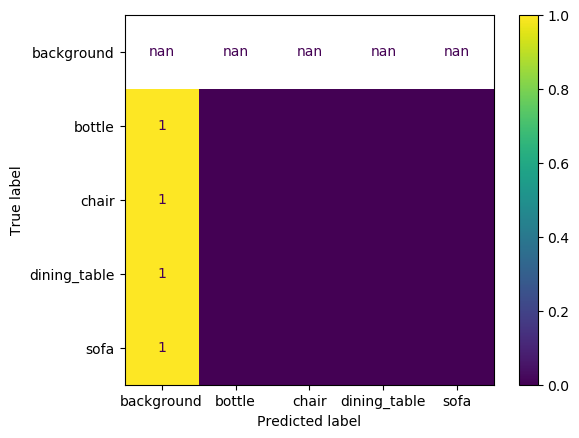

In [14]:
cm_global=results[3]
cm_global=cm_global/np.sum(cm_global,axis=1,keepdims=True)
disp=ConfusionMatrixDisplay(confusion_matrix=cm_global,display_labels=class_names)
disp.plot()
plt.show()

### 2. Influence of the threshold on the results.

#### __*Objectness threshold*__

Analize the influence of the objectness score threshold on the results of the model. To this end, you can make use of the `test_detection_model` function to check three thresholds (0.3, 0.5, 0.7). Analyze the global precisio, recall and F1-score values and discuss if they make sense.

You can also support your analysis with deeper insight (marginal inference can be shown through the `VERBOSE` parameter) and visual aid (use `SAVE_OPT` to that end).

Which threshold provides the best results? Do you think that this would be the case for all object detection problems? Justify your answer.

In [ ]:
# Include your code here
print('Threshold 0.3')
results=test_detection_model(model_ft, data_loader_test, class_names, 0.3, 0.5, result_dir, True, False, True)
#!mv baseline_results/instances_pred baseline_results/instances_pred_0_3
# Include your code here
print('Threshold 0.5')
results=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, True, False, True)
#!mv baseline_results/instances_pred baseline_results/instances_pred_0_5
# Include your code here
print('Threshold 0.7')
results=test_detection_model(model_ft, data_loader_test, class_names, 0.7, 0.5, result_dir, True, False, True)
#!mv baseline_results/instances_pred baseline_results/instances_pred_0_7

Threshold 0.3
Evaluating...


> Answer here



#### __*IoU threshold*__

Analyze the influence of the IoU threshold on the results. To this end, you can make use of the `test_detection_model` function to check three thresholds (0.3, 0.5, 0.7). You can support your analysis with deeper insight (marginal inference can be shown through the `VERBOSE` parameter) and visual aid (use `SAVE_OPT` to that end).

In [ ]:
# Include your code here
print('IoU_TH 0.3')
results=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.3, result_dir, True, False, True)
#!mv baseline_results/instances_pred baseline_results/instances_pred_iou_0_3
# Include your code here
print('IoU_TH 0.5')
results=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, True, False, True)
#!mv baseline_results/instances_pred baseline_results/instances_pred_iou_0_5
# Include your code here
print('IoU_TH 0.7')
results=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.7, result_dir, True, False, True)
#!mv baseline_results/instances_pred baseline_results/instances_pred_iou_0_7

Go back to the implementation part and analyze the code. Which were the values used for the objectness and IoU thresholds during training?

> Answer here

### 3. Analysis of the anchor sizes .

The images in the PASCAL VOC database have a maximum size of 500 pixels on their longest side and one smaller side of variable size, and therefore different aspect ratios. Note, however, that Pytorch scales images so that their minimum side measures 800 pixels or their maximum side 1333 (see the __resize__ function of __torchvision_05.models.detection.transform__). 

The following code (when uncommented) calculates the distribution of sizes and aspect ratios of objects in the train and test datasets.

In [ ]:
import matplotlib.pyplot as plt
from external import get_gt_anchors
# define training and test data loaders
data_loader_0 = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test_0 = torch.utils.data.DataLoader(
     dataset_test, batch_size=batch_size, shuffle=False, num_workers=0,
     collate_fn=utils.collate_fn)

ar_bins=[0.25,0.5,1,2,4]
log_ar_bins=np.log(ar_bins)

# TRAIN
ar, labels, size_anchors=get_gt_anchors(data_loader_0)
#We pass to logarithm to get linear distribution in x-axis
log_ar=np.log(ar)
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
ax0, ax1, ax2, ax3 = axes.flatten()
ax0.hist([log_ar[np.where(labels==1)[0]],log_ar[np.where(labels==2)[0]],log_ar[np.where(labels==3)[0]],log_ar[np.where(labels==4)[0]]],
         bins=log_ar_bins,color=['blue','orange','green','purple'],label=class_names[1:])

ax0.legend(prop={'size': 10})
ax0.set_xticks(log_ar_bins)
ax0.set_xticklabels(ar_bins)
ax0.set_title('Aspect ratio, train')
ax1.hist([size_anchors[np.where(labels==1)[0]],size_anchors[np.where(labels==2)[0]],size_anchors[np.where(labels==3)[0]],size_anchors[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax1.legend(prop={'size': 10})
ax1.set_title('Box size, train')

# TEST
ar, labels, size_anchors=get_gt_anchors(data_loader_test_0)
log_ar=np.log(ar)
ax2.hist([log_ar[np.where(labels==1)[0]],log_ar[np.where(labels==2)[0]],log_ar[np.where(labels==3)[0]],log_ar[np.where(labels==4)[0]]],
         bins=log_ar_bins,color=['blue','orange','green','purple'],label=class_names[1:])
ax2.legend(prop={'size': 10})
ax2.set_title('Aspect ratio, test')
ax2.set_xticks(log_ar_bins)
ax2.set_xticklabels(ar_bins)
ax3.hist([size_anchors[np.where(labels==1)[0]],size_anchors[np.where(labels==2)[0]],size_anchors[np.where(labels==3)[0]],size_anchors[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax3.legend(prop={'size': 10})
ax3.set_title('Box size, test')
fig.tight_layout()
plt.show()

The following one, on the other hand, calculates (once uncommented) the distribution of the anchors provided by the net.

In [ ]:
# Inference: extract the selected anchors
model_weights = torch.load(os.path.join(result_dir,'best_model.pth'.format(num_epochs-1)))['state_dict']
model_ft.load_state_dict(model_weights)
[_,_,_,_,_,_,anchors,l_t]=test_detection_model(model_ft, data_loader_test, class_names, 0.5, 0.5, result_dir, False, False, False)

# Anchor statistics
ar=[]
labels=[]
size_anchors=[]
for i in range(anchors.shape[0]):
    labels.append(l_t[i])
    size_anchors.append(np.sqrt((anchors[i,2]-anchors[i,0])*(anchors[i,3]-anchors[i,1])))
    ar.append((anchors[i,2]-anchors[i,0])/(anchors[i,3]-anchors[i,1]))

ar_bins=[0.25,0.5,1,2,4]
log_ar_bins=np.log(ar_bins)

ar=np.array(ar)
log_ar=np.log(ar)
labels=np.array(labels)
size_anchors=np.array(size_anchors)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,12))
ax0, ax1 = axes.flatten()
ax0.hist([log_ar[np.where(labels==1)[0]],log_ar[np.where(labels==2)[0]],log_ar[np.where(labels==3)[0]],log_ar[np.where(labels==4)[0]]],
         bins=log_ar_bins,color=['blue','orange','green','purple'],label=class_names[1:])
ax0.legend(prop={'size': 10})
ax0.set_xticks(log_ar_bins)
ax0.set_xticklabels(ar_bins)
ax0.set_title('Aspect ratio, train')
ax1.hist([size_anchors[np.where(labels==1)[0]],size_anchors[np.where(labels==2)[0]],size_anchors[np.where(labels==3)[0]],size_anchors[np.where(labels==4)[0]]],color=['blue','orange','green','purple'],label=class_names[1:])
ax1.legend(prop={'size': 10})
ax1.set_title('Anchor size, train')

Is the distribution of the anchors' sizes and shapes related to those of the bounding boxes provided in training and testing? Justify your answer.

> Answer here

After analyzing these results, discuss why the library changes the size of the images when these are fed to the network?

> Answer here

Provide a brief analysis of the visual output of the net, the anchors and the bounding boxes obtained through regression for a given image (you can choose some examples that help you to discuss the results).
  
Does regression work well for all cases? Does it work better for larger or smaller objects? Why do you think that happens?

> Answer here

### 4. _RoI pooling_ and classification.

In this section, a visual representation of the *RoI pooling* outputs for the different classes will be obtained using the external function `visualize_roipooling`. Furthermore, the classification results will be analyzed. Uncomment the next cell to perform the analysis.

In the following code cell, visual representations of the *RoI pooling* are extracted for each object detected in the `roipool` folder, inside the results folder. The *RoI pooling* outputs a feature map $F_r$ of size $H\times W\times C = 7\times 7\times 2048$. Each representation, in turn, corresponds to a 7x7 cell in which the maximum value of this map $F_r$ is represented over all channels (that is, each element contains the maximum value of all channels for each cell). In this way, the spatial distribution of the activations in the *RoI pooling* can be inferred. Run the following cell and analyze the output representations.

__IMPORTANT__: the mean is not used to extract the representations since in convolutional networks most of the values ​​of the channels in a certain position are usually very low, and this makes that the mean values ​​are very similar.

In [ ]:
del sys.modules['external']
from external import visualize_roipooling

# For the roi-pooling experiment, analyze the top bounding-boxes (th_score>0.7) and only those with 
# th_iou>0.7 with the ground-truth
visualize_roipooling(model_ft, data_loader_test, device, class_names, 0.7, 0.7, result_dir, True)


Visualize the outputs provided by `visualize_roipooling` (folder roi pooling) and focus on the objects that appear completely in the images. Can the shape of the object (and perhaps its category) be inferred from the spatial distribution of the RoI pooling regardless of its scale? Justify your answer.

> Answer here